In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Attention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/static/public/911/data.csv')


# Data preprocessing
# Convert 'best_score' to binary labels: positive (>=3) and negative (<3)
data['label'] = data['best_score'].apply(lambda x: 'positive' if x >= 482 else 'negative')

binary output based on the best_score

In [7]:
# Preprocessing steps for the 'review_text' column
data['review_text'] = data['text'].str.lower()
data['review_text'] = data['review_text'].str.replace(r'[^\w\s]', '', regex=True)
data['review_text'] = data['review_text'].str.replace(r'\d+', '', regex=True)
data = data.dropna(subset=['review_text'])

In [8]:
# Encode labels
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

In [9]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['review_text'])
sequences = tokenizer.texts_to_sequences(data['review_text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, data['label_encoded'], test_size=0.2, random_state=42
)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Build BiRNN model using Sequential API
birnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=100, trainable=False),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    tf.keras.layers.Dropout(0.5),
    Dense(2, activation='softmax')
])

# Define optimizer
birnn_optimizer = RMSprop(learning_rate=0.01)

# Compile BiRNN model
birnn_model.compile(
    optimizer=birnn_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train BiRNN model
birnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9497 - loss: 0.2212 - val_accuracy: 0.9502 - val_loss: 0.1985
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9503 - loss: 0.2031 - val_accuracy: 0.9502 - val_loss: 0.2053
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9506 - loss: 0.2036 - val_accuracy: 0.9502 - val_loss: 0.1973
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9482 - loss: 0.2069 - val_accuracy: 0.9502 - val_loss: 0.1977
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9515 - loss: 0.1965 - val_accuracy: 0.9502 - val_loss: 0.1986


In [11]:
def build_attbirnn_model_fixed():
    inputs = tf.keras.Input(shape=(100,))
    embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100, trainable=False)(inputs)
    birnn_layer = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(embedding_layer)
    attention_layer = AttentionLayer()(birnn_layer)
    dropout_layer = tf.keras.layers.Dropout(0.5)(attention_layer)
    outputs = Dense(2, activation='softmax')(dropout_layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build, compile, and train the corrected AttBiRNN model
attbirnn_model_fixed = build_attbirnn_model_fixed()
attbirnn_optimizer = RMSprop(learning_rate=0.001)

attbirnn_model_fixed.compile(
    optimizer=attbirnn_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the AttBiRNN model
attbirnn_model_fixed.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


NameError: name 'AttentionLayer' is not defined

In [9]:
def build_attbirnn_model_fixed():
    inputs = tf.keras.Input(shape=(100,))
    embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100, trainable=False)(inputs)
    birnn_layer = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(embedding_layer)
    attention_layer = AttentionLayer()(birnn_layer)
    dropout_layer = tf.keras.layers.Dropout(0.5)(attention_layer)
    outputs = Dense(2, activation='softmax')(dropout_layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the AttBiRNN model
attbirnn_model_fixed = build_attbirnn_model_fixed()
attbirnn_optimizer = RMSprop(learning_rate=0.001)

attbirnn_model_fixed.compile(
    optimizer=attbirnn_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the AttBiRNN model
attbirnn_model_fixed.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


ValueError: Exception encountered when calling AttentionLayer.call().

[1mCould not automatically infer the output shape / dtype of 'attention_layer_2' (of type AttentionLayer). Either the `AttentionLayer.call()` method is incorrect, or you need to implement the `AttentionLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 100 and 128 for '{{node mul}} = Mul[T=DT_FLOAT](Softmax, Placeholder)' with input shapes: [?,100], [?,100,128].[0m

Arguments received by AttentionLayer.call():
  • args=('<KerasTensor shape=(None, 100, 128), dtype=float32, sparse=False, name=keras_tensor_18>',)
  • kwargs=<class 'inspect._empty'>

Evaluating BiRNN Model...
BiRNN Accuracy: 0.95
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report for BiRNN:
              precision    recall  f1-score   support

    Negative       0.95      1.00      0.97      3455
    Positive       0.00      0.00      0.00       181

    accuracy                           0.95      3636
   macro avg       0.48      0.50      0.49      3636
weighted avg       0.90      0.95      0.93      3636

Confusion Matrix for BiRNN:


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

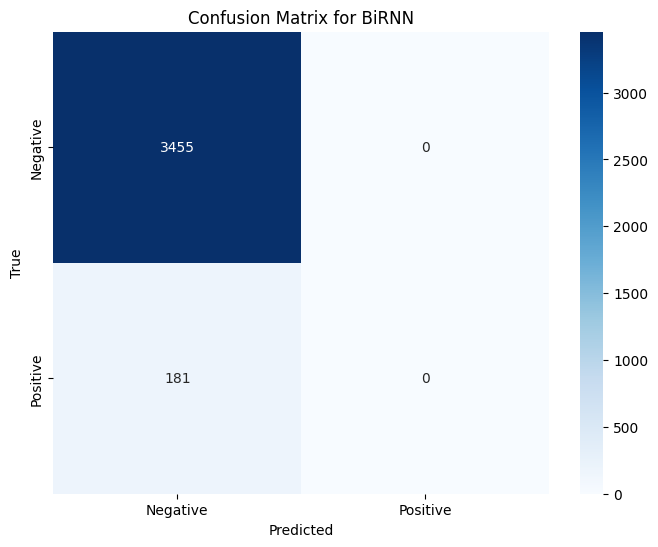

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate BiRNN model
print("Evaluating BiRNN Model...")
birnn_eval = birnn_model.evaluate(X_test, y_test, verbose=0)
print(f"BiRNN Accuracy: {birnn_eval[1]:.2f}")

# Generate predictions for BiRNN
birnn_predictions = birnn_model.predict(X_test)
birnn_pred_classes = np.argmax(birnn_predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report for BiRNN
print("\nClassification Report for BiRNN:")
print(classification_report(y_test_classes, birnn_pred_classes, target_names=['Negative', 'Positive']))

# Confusion matrix for BiRNN
print("Confusion Matrix for BiRNN:")
birnn_cm = confusion_matrix(y_test_classes, birnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(birnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for BiRNN')
plt.show()


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom Attention layer
class AttentionLayer(tf.keras.layers.Layer):
	def __init__(self, **kwargs):
		super(AttentionLayer, self).__init__(**kwargs)

	def build(self, input_shape):
		self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
		self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
		self.u = self.add_weight(shape=(input_shape[-1],), initializer='random_normal', trainable=True)

	def call(self, inputs):
		score = tf.tanh(tf.tensordot(inputs, self.W, axes=[2, 0]) + self.b)
		attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=[2, 0]), axis=1)
		context_vector = attention_weights * inputs
		context_vector = tf.reduce_sum(context_vector, axis=1)
		return context_vector

# Build the AttBiRNN model
inputs = Input(shape=(100,))
x = Embedding(input_dim=10000, output_dim=128)(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = AttentionLayer()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions
predictions = model.predict(X_test)
pred_classes = (predictions > 0.5).astype("int32")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, pred_classes, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

ValueError: Exception encountered when calling AttentionLayer.call().

[1mCould not automatically infer the output shape / dtype of 'attention_layer' (of type AttentionLayer). Either the `AttentionLayer.call()` method is incorrect, or you need to implement the `AttentionLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 100 and 256 for '{{node mul}} = Mul[T=DT_FLOAT](Softmax, Placeholder)' with input shapes: [?,100], [?,100,256].[0m

Arguments received by AttentionLayer.call():
  • args=('<KerasTensor shape=(None, 100, 256), dtype=float32, sparse=False, name=keras_tensor_16>',)
  • kwargs=<class 'inspect._empty'>

In [ ]:

# Evaluate AttBiRNN model
print("Evaluating AttBiRNN Model...")
attbirnn_eval = attbirnn_model.evaluate(X_test, y_test, verbose=0)
print(f"AttBiRNN Accuracy: {attbirnn_eval[1]:.2f}")

# Generate predictions for AttBiRNN
attbirnn_predictions = attbirnn_model.predict(X_test)
attbirnn_pred_classes = np.argmax(attbirnn_predictions, axis=1)

# Classification report for AttBiRNN
print("\nClassification Report for AttBiRNN:")
print(classification_report(y_test_classes, attbirnn_pred_classes, target_names=['Negative', 'Positive']))

# Confusion matrix for AttBiRNN
print("Confusion Matrix for AttBiRNN:")
attbirnn_cm = confusion_matrix(y_test_classes, attbirnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(attbirnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for AttBiRNN')
plt.show()


In [ ]:


# Build BiRNN Model
def build_birnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=100),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    return model

# Compile and train BiRNN
birnn_model = build_birnn_model()
birnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
birnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

# Build AttBiRNN Model
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer='random_normal', trainable=True)

    def call(self, inputs):
        score = tf.tanh(tf.tensordot(inputs, self.W, axes=[2, 0]) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=[2, 0]), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

def build_attbirnn_model():
    inputs = Input(shape=(100,))
    x = Embedding(input_dim=10000, output_dim=128, input_length=100)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionLayer()(x)
    outputs = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Compile and train AttBiRNN
attbirnn_model = build_attbirnn_model()
attbirnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
attbirnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)
